In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np
import random
from sklearn.covariance import EllipticEnvelope

class DeepConvKMeans(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_clusters, lambda_reg=0.001, mu=1.0):
        super(DeepConvKMeans, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.lambda_reg = lambda_reg
        self.mu = mu
        self.num_clusters = num_clusters

    def forward(self, x):
        x = F.selu(F.max_pool3d(self.conv1(x), kernel_size=2))
        z = F.max_pool3d(self.conv2(x), kernel_size=2)
        
        return z

    def kmeans_loss(self, Z, H):
        ZHT = Z @ H
        HHT = H.T @ H
        HHT_inv = torch.inverse(HHT)
        loss = torch.norm(Z - ZHT @ HHT_inv @ H.T, p='fro')**2
        return loss

    def regularization_loss(self, T1, T2):
        reg_loss = 0
        for Ti in [T1, T2]:
            Ti_matrix = Ti.view(Ti.size(0), -1)
            reg_loss += self.lambda_reg * (torch.norm(Ti_matrix, p='fro')**2 - torch.logdet(Ti_matrix @ Ti_matrix.T))
        return reg_loss

    def total_loss(self, Z, H, T1, T2):
        Z_flat = Z.view(Z.size(0), -1)
        loss_kmeans = self.kmeans_loss(Z_flat, H)
        loss_reg = self.regularization_loss(T1, T2)
        total_loss = loss_kmeans + loss_reg
        return total_loss

def train(model, data, num_epochs, num_clusters):
    model = model.cuda()
    data = data.cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        Z = model(data)
        Z_flat = Z.view(Z.size(0), -1)
        H = torch.rand(Z_flat.size(1), num_clusters).to(Z.device)
        T1, T2 = model.conv1.weight, model.conv2.weight
        loss = model.total_loss(Z, H, T1, T2)
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

In [2]:
data = np.load('fulldata_3d_without_4_points.npy')
data = np.expand_dims(data, axis=1)
data.shape

(127, 1, 50, 50, 50)

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
tensor_data = torch.tensor(data, dtype=torch.float32).cuda()
num_clusters = 4

model = DeepConvKMeans(in_channels=1, out_channels=8, kernel_size=3, num_clusters=num_clusters).cuda()

train(model, tensor_data, num_epochs=2000, num_clusters=num_clusters)

# print(f"Cluster assignments: {h}")
# print(f"Cluster centers: {kmeans_center}")

Epoch [1/2000], Loss: 12458.443359375
Epoch [2/2000], Loss: 8687.5380859375
Epoch [3/2000], Loss: 6232.0712890625
Epoch [4/2000], Loss: 4657.734375
Epoch [5/2000], Loss: 3708.6806640625
Epoch [6/2000], Loss: 3150.69775390625
Epoch [7/2000], Loss: 2814.942626953125
Epoch [8/2000], Loss: 2623.18017578125
Epoch [9/2000], Loss: 2518.094970703125
Epoch [10/2000], Loss: 2459.7666015625
Epoch [11/2000], Loss: 2427.359375
Epoch [12/2000], Loss: 2386.5888671875
Epoch [13/2000], Loss: 2317.55126953125
Epoch [14/2000], Loss: 2223.5576171875
Epoch [15/2000], Loss: 2102.03857421875
Epoch [16/2000], Loss: 1963.8182373046875
Epoch [17/2000], Loss: 1823.2628173828125
Epoch [18/2000], Loss: 1687.163330078125
Epoch [19/2000], Loss: 1559.4576416015625
Epoch [20/2000], Loss: 1445.5606689453125
Epoch [21/2000], Loss: 1349.255615234375
Epoch [22/2000], Loss: 1273.815673828125
Epoch [23/2000], Loss: 1216.800537109375
Epoch [24/2000], Loss: 1177.117431640625
Epoch [25/2000], Loss: 1148.557861328125
Epoch [26/

In [5]:
features = model(tensor_data)
print(features.shape)

torch.Size([127, 8, 12, 12, 12])


In [6]:
import numpy as np 
import glob

meshfiles = []
path_names = [
    "fulldata-stl/20148_région1.stl",
    "fulldata-stl/20183_région1.stl",
    "fulldata-stl/20187_région1.stl",
    "fulldata-stl/10204_région1.stl"
]
for file in glob.glob("fulldata-stl/*"):
    if file not in path_names:
        meshfiles.append(file)


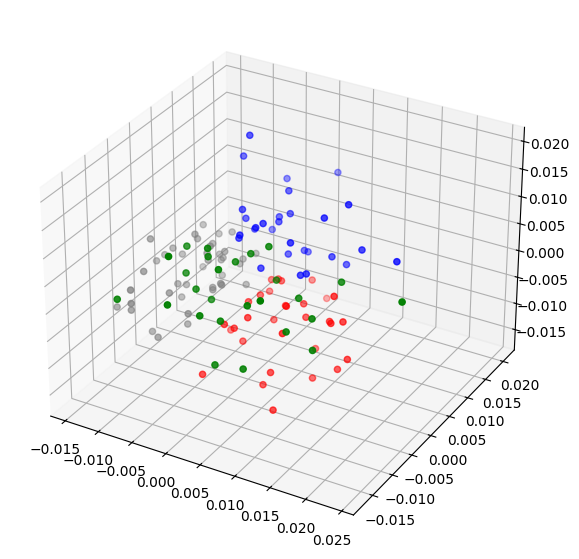

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
num_clusters = 4
colors = ['red', 'blue', 'green', 'gray', 'yellow']

flattened_data = features.view(features.size(0), -1).detach().cpu().numpy()
pca1 = PCA(n_components=3)
pca1 = pca1.fit_transform(flattened_data)

kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42)
clusters_pca = kmeans_pca.fit_predict(pca1)

cluster_colors_pca = [colors[label] for label in clusters_pca]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], c=cluster_colors_pca, marker='o')

# ax.set_title("3D Visualization of PCA-Reduced Data with Specified Colors")
# ax.set_xlabel("Principal Component 1")
# ax.set_ylabel("Principal Component 2")
# ax.set_zlabel("Principal Component 3")

plt.show()